In [1]:
#############
# Reference
# https://towardsdatascience.com/pytorch-vision-binary-image-classification-d9a227705cf9 
#

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
#import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
np.random.seed(0)
torch.manual_seed(0)
%matplotlib inline
sns.set_style('darkgrid')


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)

root_dir = "/home/mx19/datasets/hot-dog-not-hot-dog/"
print("The data lies here =>", root_dir)

image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

hotdog_dataset = datasets.ImageFolder(root = root_dir + "train",
                                      transform = image_transforms["train"]
                                     )

print(hotdog_dataset)
print(hotdog_dataset.class_to_idx)


We're using => cpu
The data lies here => /home/mx19/datasets/hot-dog-not-hot-dog/
Dataset ImageFolder
    Number of datapoints: 498
    Root location: /home/mx19/datasets/hot-dog-not-hot-dog/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
{'hot_dog': 0, 'not_hot_dog': 1}


/home/mx19/anaconda3/envs/codeVE/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /tmp/pip-req-build-pma2oi4d/c10/cuda/CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0


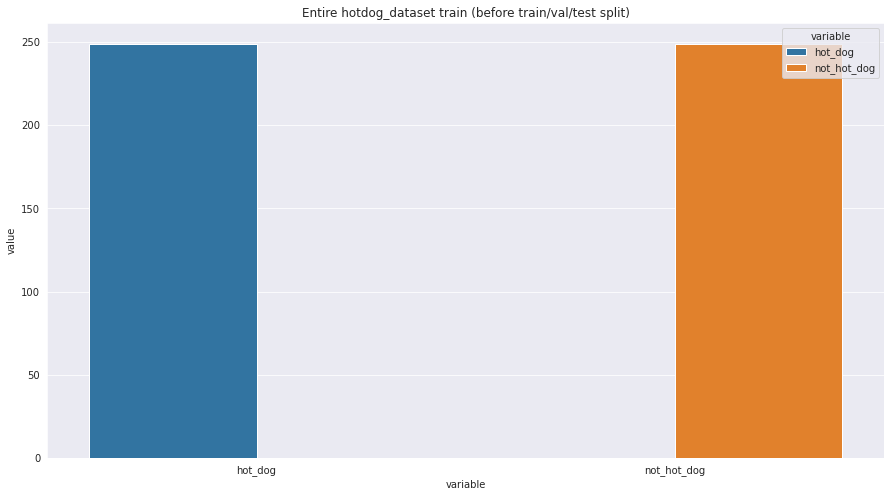

In [3]:
idx2class = {v: k for k, v in hotdog_dataset.class_to_idx.items()}
##print(idx2class) #{0: 'hot_dog', 1: 'not_hot_dog'}
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    for _, label_id in dataset_obj:
        label = idx2class[label_id]
        count_dict[label] += 1
    return count_dict


def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)


##print(get_class_distribution(hotdog_dataset)) #{'hot_dog': 249, 'not_hot_dog': 249}

plt.figure(figsize=(15,8))
plot_from_dict(get_class_distribution(hotdog_dataset), plot_title="Entire hotdog_dataset train (before train/val/test split)")
plt.show()


In [4]:
##############################
##### Model Parameters

#BATCH_SIZE = 64 #RuntimeError: Unable to find a valid cuDNN algorithm to run convolution
BATCH_SIZE = 32
LEARNING_RATE = 0.000005 # 0.009 #0.00001 #0.008; 0.001; 0.000005
EPOCHS = 25



val_split_index 99
train_idx [208, 107, 397, 71, 482, 6, 410, 113, 236, 299, 155, 272, 7, 137, 8, 429, 430, 366, 284, 210, 188, 428, 49, 134, 363, 408, 239, 59, 493, 461, 409, 483, 229, 297, 55, 293, 488, 456, 455, 421, 186, 194, 52, 74, 26, 486, 4, 318, 329, 245, 5, 141, 381, 135, 491, 122, 22, 68, 20, 367, 14, 278, 225, 64, 379, 231, 81, 354, 302, 497, 469, 453, 160, 476, 362, 494, 206, 319, 51, 306, 450, 330, 164, 106, 479, 63, 342, 425, 437, 320, 89, 312, 460, 93, 298, 457, 308, 393, 92, 18, 198, 145, 158, 150, 477, 167, 255, 230, 433, 66, 309, 253, 140, 101, 387, 2, 406, 17, 146, 249, 263, 30, 114, 247, 103, 403, 310, 176, 246, 116, 168, 413, 120, 261, 112, 417, 418, 282, 136, 190, 345, 181, 126, 281, 252, 405, 371, 352, 232, 133, 33, 474, 162, 34, 44, 97, 85, 61, 199, 268, 218, 73, 35, 303, 29, 490, 339, 441, 217, 27, 332, 378, 156, 470, 343, 138, 212, 104, 348, 344, 422, 215, 383, 189, 214, 204, 234, 259, 67, 24, 216, 223, 129, 111, 166, 415, 392, 40, 274, 355, 79, 313, 315, 13,

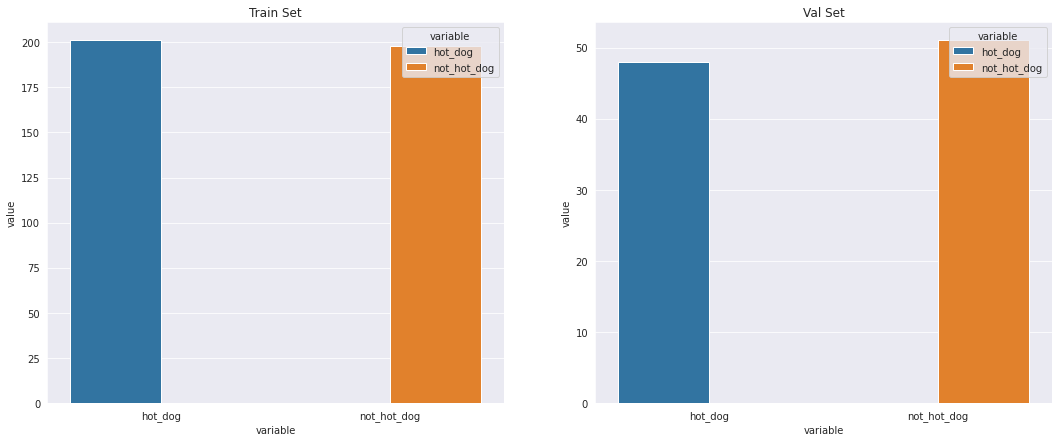

In [5]:
###########################
##### TEST

##Load our test dataset.

hotdog_dataset_size = len(hotdog_dataset)
hotdog_dataset_indices = list(range(hotdog_dataset_size))
#print(hotdog_dataset_size) # 498
#print(hotdog_dataset_indices) # [0, 1, 2, 3 ...... 495, 496, 497]

np.random.shuffle(hotdog_dataset_indices)

################################################################
# We choose the split index to be 20% (0.2) of the dataset size.

# train_split_index = int(np.floor(0.03 * hotdog_dataset_size))
# val_split_index = int(np.floor(0.97 * hotdog_dataset_size))
val_split_index = int(np.floor(0.2 * hotdog_dataset_size))
#print(f'train_split_index {train_split_index}')
print(f'val_split_index {val_split_index}')

train_idx = hotdog_dataset_indices[val_split_index:]
val_idx = hotdog_dataset_indices[:val_split_index]
print(f'train_idx {train_idx}') # [train_split_index ...  hotdog_dataset_size]
print(f'val_idx {val_idx}') # [0... val_split_index]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)


train_loader = DataLoader(dataset=hotdog_dataset, shuffle=False, batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = DataLoader(dataset=hotdog_dataset, shuffle=False, batch_size=1, sampler=val_sampler)


print(train_loader.dataset)
print(val_loader.dataset)



hotdog_dataset_test = datasets.ImageFolder(root = root_dir + "test",
                                            transform = image_transforms["test"]
                                           )
test_loader = DataLoader(dataset=hotdog_dataset_test, shuffle=False, batch_size=1)
print(f'hotdog_dataset_test: {hotdog_dataset_test}')


def get_class_distribution_loaders(dataloader_obj, dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    if dataloader_obj.batch_size == 1:
        for _,label_id in dataloader_obj:
            y_idx = label_id.item()
            y_lbl = idx2class[y_idx]
            count_dict[str(y_lbl)] += 1
    else:
        for _,label_id in dataloader_obj:
            for idx in label_id:
                y_idx = idx.item()
                y_lbl = idx2class[y_idx]
                count_dict[str(y_lbl)] += 1
    return count_dict


print(get_class_distribution_loaders(train_loader, hotdog_dataset))
print(get_class_distribution_loaders(val_loader, hotdog_dataset))
print(get_class_distribution_loaders(test_loader, hotdog_dataset))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,7))
plot_from_dict(get_class_distribution_loaders(train_loader, hotdog_dataset), plot_title="Train Set", ax=axes[0])
plot_from_dict(get_class_distribution_loaders(val_loader, hotdog_dataset), plot_title="Val Set", ax=axes[1])
plt.show()


torch.Size([32, 3, 224, 224])
Output label tensors:  tensor([0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 1, 0])

Output label tensor shape:  torch.Size([32])
torch.Size([3, 224, 224])


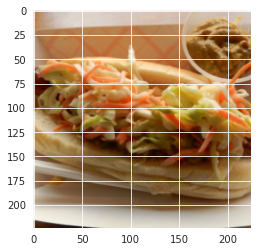

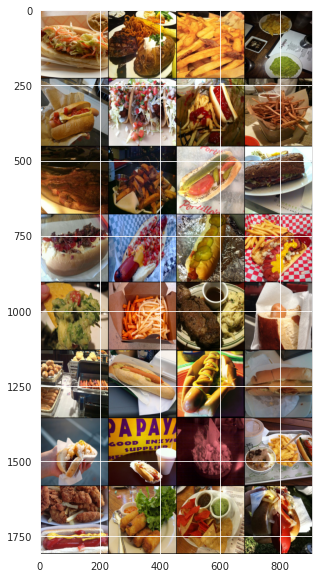

In [6]:
single_batch = next(iter(train_loader))
#single_batch = next(iter(val_loader))
print(single_batch[0].shape)

print("Output label tensors: ", single_batch[1])
print("\nOutput label tensor shape: ", single_batch[1].shape)


# Selecting the first image tensor from the batch.
single_image = single_batch[0][0]
print(single_image.shape)
plt.imshow(single_image.cpu().detach().numpy().transpose((1, 2, 0)))
plt.show()

# We do single_batch[0] because each batch is a list
# where the 0th index is the image tensor and 1st index is the output label.
single_batch_grid = utils.make_grid(single_batch[0], nrow=4)
plt.figure(figsize = (10,10))
plt.imshow(single_batch_grid.permute(1, 2, 0))
plt.show()


In [7]:

class HotDogClassifier(nn.Module):
    def __init__(self):
        super(HotDogClassifier, self).__init__()
        self.block1 = self.conv_block(c_in=3, c_out=256, dropout=0.1, kernel_size=5, stride=1, padding=2)
        self.block2 = self.conv_block(c_in=256, c_out=128, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.block3 = self.conv_block(c_in=128, c_out=64, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.lastcnn = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=56, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.block1(x)
        x = self.maxpool(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.maxpool(x)
        x = self.lastcnn(x)
        return x

    def conv_block(self, c_in, c_out, dropout,  **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU(),
            nn.Dropout2d(p=dropout)
        )
        return seq_block


In [8]:


model = HotDogClassifier()
model.to(device)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)



HotDogClassifier(
  (block1): Sequential(
    (0): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (lastcnn): Conv2d(64, 2, kernel_size=(56, 56), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [9]:
# function to calculate accuracy per epoch.
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc


#We’ll also define 2 dictionaries which will store the accuracy/epoch and loss/epoch for both train and validation sets.
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}


In [10]:
#########################
## Let’s TRAIN our model!


print("Begin training.")
epoch_number = EPOCHS

for e in tqdm(range(1, epoch_number)):

    ## TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        y_train_pred = model(X_train_batch).squeeze()
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = binary_acc(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()

    ## VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch).squeeze()
            y_val_pred = torch.unsqueeze(y_val_pred, 0)
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = binary_acc(y_val_pred, y_val_batch)
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()

    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))

    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
            
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')


Begin training.


  0%|                                                                                                                                                                  | 0/24 [00:00<?, ?it/s]/home/mx19/anaconda3/envs/codeVE/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-pma2oi4d/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  4%|██████▍                                                                                                                                                   | 1/24 [01:36<37:06, 96.80s/it]

Epoch 01: | Train Loss: 0.74224 | Val Loss: 0.69393 | Train Acc: 47.923| Val Acc: 51.515


  8%|████████████▊                                                                                                                                             | 2/24 [03:11<35:00, 95.50s/it]

Epoch 02: | Train Loss: 0.64716 | Val Loss: 0.68462 | Train Acc: 62.769| Val Acc: 58.586


 12%|███████████████████▎                                                                                                                                      | 3/24 [04:51<34:07, 97.51s/it]

Epoch 03: | Train Loss: 0.58764 | Val Loss: 0.71140 | Train Acc: 68.462| Val Acc: 55.556


 17%|█████████████████████████▋                                                                                                                                | 4/24 [06:26<32:12, 96.62s/it]

Epoch 04: | Train Loss: 0.54026 | Val Loss: 0.67113 | Train Acc: 72.385| Val Acc: 61.616


 21%|████████████████████████████████                                                                                                                          | 5/24 [08:01<30:24, 96.02s/it]

Epoch 05: | Train Loss: 0.51138 | Val Loss: 0.68508 | Train Acc: 76.385| Val Acc: 65.657


 25%|██████████████████████████████████████▌                                                                                                                   | 6/24 [09:38<28:54, 96.36s/it]

Epoch 06: | Train Loss: 0.49172 | Val Loss: 0.73013 | Train Acc: 79.308| Val Acc: 58.586


 29%|████████████████████████████████████████████▉                                                                                                             | 7/24 [11:13<27:07, 95.76s/it]

Epoch 07: | Train Loss: 0.47117 | Val Loss: 0.69535 | Train Acc: 79.077| Val Acc: 58.586


 33%|███████████████████████████████████████████████████▎                                                                                                      | 8/24 [12:50<25:41, 96.33s/it]

Epoch 08: | Train Loss: 0.44992 | Val Loss: 0.67970 | Train Acc: 82.154| Val Acc: 57.576


 38%|█████████████████████████████████████████████████████████▊                                                                                                | 9/24 [14:35<24:43, 98.87s/it]

Epoch 09: | Train Loss: 0.42098 | Val Loss: 0.70087 | Train Acc: 85.462| Val Acc: 58.586


 42%|███████████████████████████████████████████████████████████████▊                                                                                         | 10/24 [16:09<22:42, 97.36s/it]

Epoch 10: | Train Loss: 0.41763 | Val Loss: 0.65735 | Train Acc: 83.846| Val Acc: 65.657


 46%|██████████████████████████████████████████████████████████████████████▏                                                                                  | 11/24 [17:43<20:54, 96.47s/it]

Epoch 11: | Train Loss: 0.36412 | Val Loss: 0.66780 | Train Acc: 89.231| Val Acc: 60.606


 50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 12/24 [19:19<19:14, 96.22s/it]

Epoch 12: | Train Loss: 0.34193 | Val Loss: 0.69977 | Train Acc: 90.692| Val Acc: 58.586


 54%|██████████████████████████████████████████████████████████████████████████████████▉                                                                      | 13/24 [20:56<17:40, 96.42s/it]

Epoch 13: | Train Loss: 0.33316 | Val Loss: 0.68007 | Train Acc: 92.769| Val Acc: 59.596


 58%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 14/24 [22:33<16:06, 96.63s/it]

Epoch 14: | Train Loss: 0.32227 | Val Loss: 0.67762 | Train Acc: 91.462| Val Acc: 61.616


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 15/24 [24:07<14:24, 96.05s/it]

Epoch 15: | Train Loss: 0.30098 | Val Loss: 0.67823 | Train Acc: 92.923| Val Acc: 62.626


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 16/24 [25:41<12:43, 95.39s/it]

Epoch 16: | Train Loss: 0.31654 | Val Loss: 0.67738 | Train Acc: 89.462| Val Acc: 60.606


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 17/24 [27:15<11:03, 94.84s/it]

Epoch 17: | Train Loss: 0.29864 | Val Loss: 0.72148 | Train Acc: 91.462| Val Acc: 54.545


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 18/24 [28:48<09:26, 94.34s/it]

Epoch 18: | Train Loss: 0.25971 | Val Loss: 0.68044 | Train Acc: 97.231| Val Acc: 60.606


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 19/24 [30:21<07:49, 93.88s/it]

Epoch 19: | Train Loss: 0.25854 | Val Loss: 0.68597 | Train Acc: 96.231| Val Acc: 60.606


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 20/24 [31:54<06:15, 93.84s/it]

Epoch 20: | Train Loss: 0.24944 | Val Loss: 0.72322 | Train Acc: 96.923| Val Acc: 55.556


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 21/24 [33:27<04:40, 93.41s/it]

Epoch 21: | Train Loss: 0.23632 | Val Loss: 0.68745 | Train Acc: 97.231| Val Acc: 63.636


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 22/24 [34:59<03:06, 93.03s/it]

Epoch 22: | Train Loss: 0.22712 | Val Loss: 0.69085 | Train Acc: 97.000| Val Acc: 64.646


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 23/24 [36:33<01:33, 93.31s/it]

Epoch 23: | Train Loss: 0.23928 | Val Loss: 0.69081 | Train Acc: 96.692| Val Acc: 61.616


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [38:07<00:00, 95.32s/it]

Epoch 24: | Train Loss: 0.21889 | Val Loss: 0.73302 | Train Acc: 97.462| Val Acc: 55.556


Text(0.5, 1.0, 'Train-Val Loss/Epoch EPOCHS=25 BATCH_SIZE=32 LEARNING_RATE=5e-06')

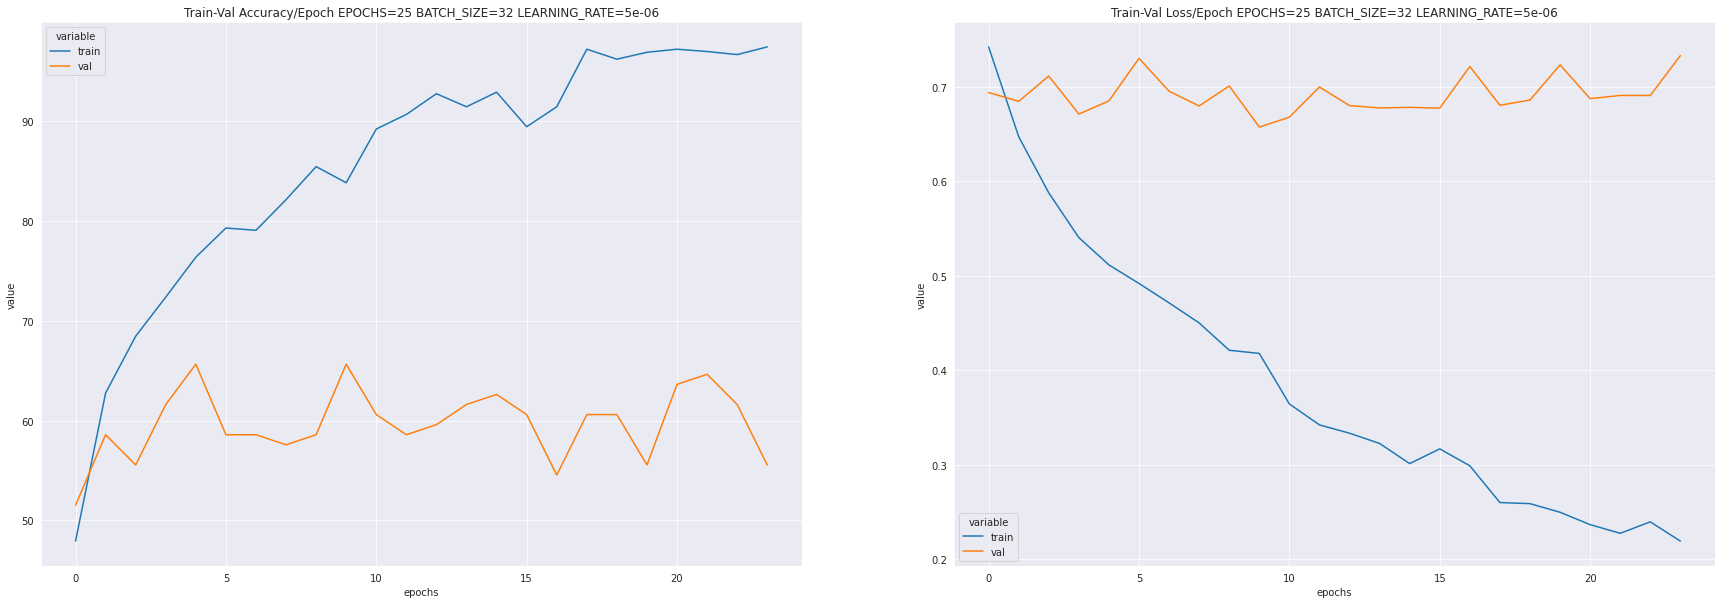

In [11]:
#Visualize Loss and Accuracy
#To plot the loss and accuracy line plots, we again create a dataframe from the accuracy_stats and 
#loss_stats dictionaries.

#print(len(accuracy_stats['train']))
#print(len(accuracy_stats['val']))
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# print((train_val_acc_df))

#print(len(loss_stats['train']))
#print(len(loss_stats['val']))
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
#print(train_val_loss_df)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title(f'Train-Val Accuracy/Epoch EPOCHS={EPOCHS} BATCH_SIZE={BATCH_SIZE} LEARNING_RATE={LEARNING_RATE}')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title(f'Train-Val Loss/Epoch EPOCHS={EPOCHS} BATCH_SIZE={BATCH_SIZE} LEARNING_RATE={LEARNING_RATE}')




In [12]:

y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)        
        
        y_test_pred = model(x_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)        
        
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())
        

#We’ll flatten out the list so that we can use it as an input to confusion_matrix and classification_report.        
y_pred_list = [i[0][0][0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]        


print(f'y_pred_list{y_pred_list}')
print(f'y_true_list{y_true_list}')


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:32<00:00, 15.39it/s]

y_pred_list[0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0

In [13]:
print(classification_report(y_true_list, y_pred_list))
print(confusion_matrix(y_true_list, y_pred_list))


              precision    recall  f1-score   support

           0       0.59      0.71      0.64       250
           1       0.63      0.50      0.56       250

    accuracy                           0.60       500
   macro avg       0.61      0.60      0.60       500
weighted avg       0.61      0.60      0.60       500

[[177  73]
 [125 125]]


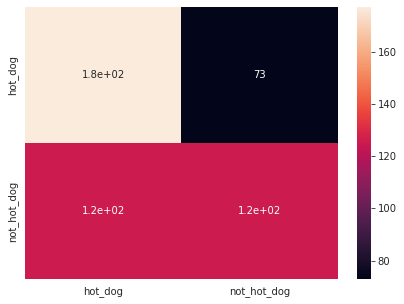

In [14]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list)).rename(columns=idx2class, index=idx2class)

fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)
plt.show()